<p id = 'toc'></p>

<h1 style = "font-family:Verdana; font-size:24px; font-weight: bold; letter-spacing: 3px; color: teal;"> TABLE OF CONTENTS </h1>

---

[<h3 style = "font-family: Verdana; font-size: 18px; text-indent: 8vw; letter-spacing: 2px; color: teal">0&nbsp;&nbsp;&nbsp;&nbsp; IMPORTS </h3>](#0)

---

<h3 style = "font-family:Verdana; font-size: 18px; text-indent: 8vw; letter-spacing: 2px; color: teal"><a href='#1'>1.&nbsp;&nbsp;&nbsp;&nbsp;DATASET</a></h3>

---

<h3 style = "font-family:Verdana; font-size: 18px; text-indent: 8vw; letter-spacing: 2px; color: teal"><a href='#2'>2.&nbsp;&nbsp;&nbsp;&nbsp;CONVERTING IMAGE DATA TO JPG</a></h3>

---

<h3 style = "font-family:Verdana; font-size: 18px; text-indent: 8vw; letter-spacing: 2px; color: teal"><a href='#3'>3.&nbsp;&nbsp;&nbsp;&nbsp;VISUALIZATIONS</a></h3>

---

<h3 style = "font-family:Verdana; font-size: 18px; text-indent: 8vw; letter-spacing: 2px; color: teal"><a href='#4'>4.&nbsp;&nbsp;&nbsp;&nbsp;DATA LOADER</a></h3>


<a id = '0'></a>
# <span><center style = "font-family: Verdana; font-size:36px; color : teal; letter-spacing: 3px; font-weight: bold">0. &nbsp;IMPORTS&nbsp;&nbsp;&nbsp;&nbsp;<a href = '#toc'>&#10514;</a></center></span>

In [1]:
# pip install pydicom

In [30]:
import pandas as pd 
import numpy as np
import os
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import torch
import cv2
import torchvision.transforms as transforms
import shutil
import random


from PIL import Image
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.io import read_image
from pydicom import dcmread
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

import warnings
warnings.filterwarnings("ignore")

%config Completer.use_jedi = False

In [31]:
class config:
    TRAIN_PATH = '../input/unifesp-x-ray-body-part-classifier/train'
    TRAIN_CSV = '../input/unifesp-x-ray-body-part-classifier/train.csv'
    WORKING_PATH = './'
    TRAIN_JPG_PATH = '../input/unifesp-xray-body-part-classifier-jpg'
    RANDOM_SEED = 15
    resize_size = [270,270]
    img_size = [256,256]
    train_bs = 32
    val_bs = 64
    device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")
    

In [32]:
def set_seed(seed = config.RANDOM_SEED):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    print("--> SEEDING DONE")
    
    
set_seed()

--> SEEDING DONE


<a id="1"></a>

# <span><center style= "font-family:Verdana; font-size:36px; font-weight: bold; letter-spacing: 3px; color: teal">1.&nbsp;&nbsp;DATASET&nbsp;&nbsp;&nbsp;&nbsp;<a href = '#toc'>&#10514;</a> </center></span>

In [33]:
train_df = pd.read_csv(config.TRAIN_CSV)
train_df.head(10)

,SOPInstanceUID,Target
0,1.2.826.0.1.3680043.8.498.10025629581362719970...,0
1,1.2.826.0.1.3680043.8.498.10036150326276641158...,15
2,1.2.826.0.1.3680043.8.498.10038426859954986240...,12
3,1.2.826.0.1.3680043.8.498.10050991192143676483...,14
4,1.2.826.0.1.3680043.8.498.10053309524595490852...,3
5,1.2.826.0.1.3680043.8.498.10053755320637729867...,3
6,1.2.826.0.1.3680043.8.498.10062189329714053601...,14
7,1.2.826.0.1.3680043.8.498.10065930002825553435...,13 20
8,1.2.826.0.1.3680043.8.498.10072001800484199846...,3
9,1.2.826.0.1.3680043.8.498.10077219503857952412...,3


In [34]:
def image_path_creation(path, replace_part):
    file_names = []
    full_paths = []
    for dirpath,  dirname, filenames in os.walk(path):
        if filenames:
            for filename in filenames:
                full_path = os.path.join(dirpath, filename)
                filename = filename.replace(replace_part, '')
                full_paths.append(full_path)
                file_names.append(filename)
    return file_names, full_paths

In [35]:
file_names, full_paths = image_path_creation(config.TRAIN_PATH, '-c.dcm')
image_path_dict = {'SOPInstanceUID': file_names, 'path':full_paths}
image_df = pd.DataFrame(image_path_dict)

In [36]:
train_df = pd.merge(train_df, image_df, on = 'SOPInstanceUID')

In [37]:
train_df.head(8)

,SOPInstanceUID,Target,path
0,1.2.826.0.1.3680043.8.498.10025629581362719970...,0,../input/unifesp-x-ray-body-part-classifier/tr...
1,1.2.826.0.1.3680043.8.498.10036150326276641158...,15,../input/unifesp-x-ray-body-part-classifier/tr...
2,1.2.826.0.1.3680043.8.498.10038426859954986240...,12,../input/unifesp-x-ray-body-part-classifier/tr...
3,1.2.826.0.1.3680043.8.498.10050991192143676483...,14,../input/unifesp-x-ray-body-part-classifier/tr...
4,1.2.826.0.1.3680043.8.498.10053309524595490852...,3,../input/unifesp-x-ray-body-part-classifier/tr...
5,1.2.826.0.1.3680043.8.498.10053755320637729867...,3,../input/unifesp-x-ray-body-part-classifier/tr...
6,1.2.826.0.1.3680043.8.498.10062189329714053601...,14,../input/unifesp-x-ray-body-part-classifier/tr...
7,1.2.826.0.1.3680043.8.498.10065930002825553435...,13 20,../input/unifesp-x-ray-body-part-classifier/tr...


In [38]:
train_df.shape

(1738, 3)

<a id="2"></a>

# <span><center style = "font-family:Verdana; font-size:36px; letter-spacing:2px; font-weight:bold; color:teal">2.&nbsp;&nbsp;CONVERTING IMAGE DATA TO JPG&nbsp;&nbsp;&nbsp;&nbsp;<a href='#toc'>&#10514;</a></center></span>

In [ ]:
def read_dicom_image(path):
    dicom_file = dcmread(path)
    image = dicom_file.pixel_array
    image = image/image.max()
    return image

In [ ]:
def save_image_jpg(path, save_path_name):
    image = read_dicom_image(path)*255
    plt.imsave(save_path_name, image)

In [ ]:
os.listdir()

In [ ]:
# shutil.rmtree('./train')

In [ ]:
# Saving jpg images to working directory

# os.mkdir('./train')

# for i in tqdm(range(1000, train_df.shape[0])):
#     save_image_jpg(train_df.path[i], f'./train/{train_df.SOPInstanceUID[i]}.jpg')

In [ ]:
file_names, file_paths = image_path_creation(config.TRAIN_JPG_PATH, '.jpg')
image_df = {'SOPInstanceUID': file_names, 'path_jpg':file_paths}
image_df = pd.DataFrame(image_df)

In [ ]:
os.listdir(config.TRAIN_JPG_PATH)

In [ ]:
image_df#, train_df.SOPInstanceUID[0]

In [ ]:
train_df_jpg=pd.merge(train_df, image_df, on = 'SOPInstanceUID')

In [ ]:
train_df_jpg.head()

In [ ]:
train_df_jpg.SOPInstanceUID[0], train_df_jpg.path_jpg[0].split('/')[-1]

<a id="3"></a>

# <span><center style = "font-family:Didot; font-size:36px; letter-spacing:2px; font-weight:bold; color:teal">3.&nbsp;&nbsp;DATA EXPLORATION AND VISUALIZATIONS&nbsp;&nbsp;&nbsp;&nbsp;<a href='#toc'>&#10514;</a></center></span>

In [39]:
train_df.Target.value_counts()

3            724
14           120
11           102
0             80
2             77
6             70
15            67
21            63
13 20         45
9 21          42
1             41
16            40
13            39
9             31
17            23
5             23
12            19
10            19
7             15
20            15
8             12
0 3           11
18            10
4              9
19             7
1 6            7
1 11 12        5
10 19          4
2 13 20        3
5 8            2
10 11 19       2
15 19          2
2 20           1
3 7            1
1 12           1
7 9            1
3 6            1
0 15           1
3 15           1
11 12          1
8 16           1
Name: Target, dtype: int64

So there is Some problem in labels, lets check them out

In [40]:
train_df.dtypes

SOPInstanceUID    object
Target            object
path              object
dtype: object

In [41]:
train_df['label_count']=train_df.Target.map(lambda x: len(x.split()))

In [47]:
 multiple_labels = train_df[train_df.label_count > 1]

NameError: name 'train_df_jpg' is not defined

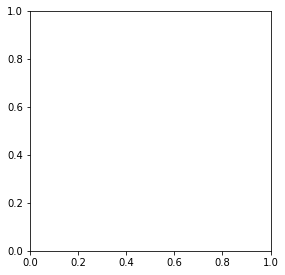

In [48]:
fig = plt.figure(figsize=(25,15))
for i in range(15):
    ax = fig.add_subplot(3,5, i+1)
#     image = read_dicom_image(train_df.path_jpg[i*5])
    img = np.array(Image.open(train_df_jpg.path_jpg[i*5]))
    plt.imshow(img, cmap = 'gray')
    ax.set_title(train_df.Target[i*5])

In [ ]:
img = cv2.imread(train_df_jpg.path_jpg[5])
plt.imshow(img)

<a id="4"></a>

# <span><center style = "font-family:Verdana; font-size:36px; letter-spacing:2px; font-weight:bold; color:teal">4.&nbsp;&nbsp;DATA LOADER&nbsp;&nbsp;&nbsp;&nbsp;<a href='#toc'>&#10514;</a></center></span>


In [ ]:
# Custom dataset

class CustomeImageDataset(Dataset):
    
    def __init__(self, data_frame, path_col, label_col, transform = None):
        self.path  = data_frame[path_col]
        self.label = data_frame[label_col]
        self.transform = transform
        
    def __len__(self):
        return len(self.label)
    
    def __getitem__(self, idx):
        img_path = self.path[idx]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#         image = np.expand_dims(image, axis = 0)
        label = self.label[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

In [ ]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(270),
    transforms.CenterCrop(256),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(0.3),
    transforms.ToTensor()
])

In [ ]:
image_dataset = CustomeImageDataset(train_df_jpg, 'path_jpg', 'Target', transform)

In [ ]:
# Creating dataset for training and validation=

valid_size = 0.3


num_train = len(image_dataset)
indices = list(range(num_train))
np.random.shuffle(indices)

split = int(np.floor(num_train * valid_size))
train_idx, val_idx =  indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

train_loader = DataLoader(image_dataset, batch_size = config.train_bs, 
                      sampler = train_sampler)
val_loader = DataLoader(image_dataset, batch_size = config.val_bs,
                       sampler = val_sampler)



In [ ]:
images, labels = next(iter(train_loader))

In [ ]:
images.shape